# Email Fraud Detection: Simple Modeling

#### Ross Willett

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Email-Fraud-Detection:-Simple-Modeling" data-toc-modified-id="Email-Fraud-Detection:-Simple-Modeling-1">Email Fraud Detection: Simple Modeling</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Ross-Willett" data-toc-modified-id="Ross-Willett-1.0.0.1">Ross Willett</a></span></li></ul></li></ul></li><li><span><a href="#File-Introduction" data-toc-modified-id="File-Introduction-1.1">File Introduction</a></span></li><li><span><a href="#Initial-Formatting" data-toc-modified-id="Initial-Formatting-1.2">Initial Formatting</a></span></li><li><span><a href="#Model-Building" data-toc-modified-id="Model-Building-1.3">Model Building</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression-Model" data-toc-modified-id="Logistic-Regression-Model-1.3.1">Logistic Regression Model</a></span></li><li><span><a href="#SVM-Model" data-toc-modified-id="SVM-Model-1.3.2">SVM Model</a></span></li><li><span><a href="#KNN-Model" data-toc-modified-id="KNN-Model-1.3.3">KNN Model</a></span></li><li><span><a href="#Decision-Tree-Model" data-toc-modified-id="Decision-Tree-Model-1.3.4">Decision Tree Model</a></span></li><li><span><a href="#Naive-Bayes-Model" data-toc-modified-id="Naive-Bayes-Model-1.3.5">Naive Bayes Model</a></span></li><li><span><a href="#Comparing-The-Model-Results" data-toc-modified-id="Comparing-The-Model-Results-1.3.6">Comparing The Model Results</a></span></li><li><span><a href="#TFIDF-Vectorizer" data-toc-modified-id="TFIDF-Vectorizer-1.3.7">TFIDF Vectorizer</a></span></li><li><span><a href="#TFIDF-Logistic-Regression" data-toc-modified-id="TFIDF-Logistic-Regression-1.3.8">TFIDF Logistic Regression</a></span></li><li><span><a href="#TFIDF-SVM" data-toc-modified-id="TFIDF-SVM-1.3.9">TFIDF SVM</a></span></li><li><span><a href="#TFIDF-KNN" data-toc-modified-id="TFIDF-KNN-1.3.10">TFIDF KNN</a></span></li><li><span><a href="#TFIDF-Decision-Tree" data-toc-modified-id="TFIDF-Decision-Tree-1.3.11">TFIDF Decision Tree</a></span></li><li><span><a href="#TFIDF-Naive-Bayes" data-toc-modified-id="TFIDF-Naive-Bayes-1.3.12">TFIDF Naive Bayes</a></span></li><li><span><a href="#Comparing-TFIDF-and-Count-Vectorized-Results" data-toc-modified-id="Comparing-TFIDF-and-Count-Vectorized-Results-1.3.13">Comparing TFIDF and Count Vectorized Results</a></span></li><li><span><a href="#Build-Test-Pipelines" data-toc-modified-id="Build-Test-Pipelines-1.3.14">Build Test Pipelines</a></span></li></ul></li><li><span><a href="#Save-The-Model" data-toc-modified-id="Save-The-Model-1.4">Save The Model</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-1.5">Conclusion</a></span></li></ul></li></ul></div>

## File Introduction

In this file, several models will be built using the vectorized text data and additional numerical columns. The performance of these models will be evaluated and the hyperparameters optimized to find the best model of these simple models.

## Initial Formatting

First the the remainder and test data must be loaded into the file. Then in order to prevent any data leakage, the remainder set must be split into train and validation sets.

In [148]:
# Import data manipulation libraries
import pandas as pd
import numpy as np

# Import regex library
import re

# Import math library
import math

# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import natural language processing libraries
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Import model selection libraries
from sklearn.model_selection import train_test_split, GridSearchCV

# Import processing libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

# Import modeling libraries
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC

# Import dimensionality reduction library
from sklearn.decomposition import PCA

# Import model Evaluation Libraries
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Import pipeline library
from sklearn.pipeline import Pipeline

# Import temporary file creation library
from tempfile import mkdtemp

# Import Pickling library
import pickle

# Import custom tokenizer
from Tokenizer import custom_tokenizer

In [149]:
# Import warnings and supress them
import warnings
warnings.filterwarnings('ignore')

In [150]:
# Configure Pandas to show all columns / rows
pd.options.display.max_columns = 2000
pd.options.display.max_rows = 2000
# Set column max width larger
pd.set_option('display.max_colwidth', 500)

In [151]:
# Set up matplotlib to use nice styles
plt.style.use('ggplot')

In [152]:
# Load X remainder
X_remainder = pd.read_csv('./data/X_remainder.csv')
# Load X test
X_test = pd.read_csv('./data/X_test.csv')
# Load y remainder
y_remainder = pd.read_csv('./data/y_remainder.csv')
# Load y test
y_test = pd.read_csv('./data/y_test.csv')

In [153]:
# Split the data frames into train and validation data
X_train, X_validation, y_train, y_validation = train_test_split(
    X_remainder,
    y_remainder,
    stratify=y_remainder,
    random_state=1337,
    test_size=0.2,
)
# Reset the indexes of the resulting data frames so the counts return to 1 to n
X_train.reset_index(drop=True, inplace=True)
X_validation.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_validation.reset_index(drop=True, inplace=True)

Now that the data has been split into train, validation and test data, the count vectorizer can be fit on the train data and used to transform the other data sets. The vectorizer will be set to use a custom tokenizer which will remove stop words and stem each word. This vectorizer will also require a minimum frequency of 5% for any word to be used in the vectorizer. This will reduce any over-fitting for any models trained on the data set.

In [154]:
# Initialize a column transformer to be used to vectorize the text content and pass through the other columns
cv_transf = ColumnTransformer([
        (
            # Set the name of the transformer
            'count_vectorizer',
            # Intantiate the count vectorizer
            CountVectorizer(
                # Set the tokenizer for the vectorizer to the custom tokenizer
                tokenizer=custom_tokenizer,
                # Set a minimum requirement of 5% frequency for words to be used for vectorizer
                min_df=0.05
            ),
            # Set the target column of the count vectorizer
            'content',
        )
    ],
    # Specify that all other columns for the data frame should be left as-is
    remainder='passthrough'
)

In [155]:
# Fit and transform the data for the training data set
X_train_vec = cv_transf.fit_transform(X_train)

In [156]:
# Create a data frame from the vectorized data
X_train_vec = pd.DataFrame(
    data=X_train_vec.toarray(),
    columns=cv_transf.get_feature_names_out(),
)
# Look at the top 10 entries in the data frame
X_train_vec.head(10)

,count_vectorizer__abl,count_vectorizer__accept,count_vectorizer__access,count_vectorizer__accord,count_vectorizer__account,count_vectorizer__actual,count_vectorizer__address,count_vectorizer__agre,count_vectorizer__agreement,count_vectorizer__along,count_vectorizer__also,count_vectorizer__amount,count_vectorizer__anoth,count_vectorizer__arrang,count_vectorizer__ask,count_vectorizer__assist,count_vectorizer__assur,count_vectorizer__attent,count_vectorizer__back,count_vectorizer__bank,count_vectorizer__base,count_vectorizer__behalf,count_vectorizer__believ,count_vectorizer__beneficiari,count_vectorizer__best,count_vectorizer__bless,count_vectorizer__busi,count_vectorizer__call,count_vectorizer__care,count_vectorizer__case,count_vectorizer__chang,count_vectorizer__choos,count_vectorizer__claim,count_vectorizer__click,count_vectorizer__client,count_vectorizer__close,count_vectorizer__come,count_vectorizer__commun,count_vectorizer__compani,count_vectorizer__complet,count_vectorizer__concern,count_vectorizer__confid,count_vectorizer__confidenti,count_vectorizer__confirm,count_vectorizer__contact,count_vectorizer__corpor,count_vectorizer__could,count_vectorizer__countri,count_vectorizer__cours,count_vectorizer__current,count_vectorizer__custom,count_vectorizer__day,count_vectorizer__deal,count_vectorizer__dear,count_vectorizer__death,count_vectorizer__deceas,count_vectorizer__decid,count_vectorizer__depart,count_vectorizer__deposit,count_vectorizer__develop,count_vectorizer__direct,count_vectorizer__discov,count_vectorizer__discuss,count_vectorizer__done,count_vectorizer__due,count_vectorizer__easi,count_vectorizer__enabl,count_vectorizer__end,count_vectorizer__even,count_vectorizer__everi,count_vectorizer__execut,count_vectorizer__fact,count_vectorizer__faith,count_vectorizer__famili,count_vectorizer__father,count_vectorizer__file,count_vectorizer__final,count_vectorizer__financi,count_vectorizer__find,count_vectorizer__first,count_vectorizer__five,count_vectorizer__follow,count_vectorizer__foreign,count_vectorizer__form,count_vectorizer__former,count_vectorizer__forward,count_vectorizer__free,count_vectorizer__friend,count_vectorizer__full,count_vectorizer__fund,count_vectorizer__futur,count_vectorizer__gener,count_vectorizer__get,count_vectorizer__give,count_vectorizer__given,count_vectorizer__go,count_vectorizer__god,count_vectorizer__good,count_vectorizer__got,count_vectorizer__govern,count_vectorizer__great,count_vectorizer__group,count_vectorizer__hear,count_vectorizer__help,count_vectorizer__henc,count_vectorizer__home,count_vectorizer__hope,count_vectorizer__hous,count_vectorizer__howev,count_vectorizer__hundr,count_vectorizer__id,count_vectorizer__immedi,count_vectorizer__import,count_vectorizer__includ,count_vectorizer__inform,count_vectorizer__interest,count_vectorizer__intern,count_vectorizer__invest,count_vectorizer__involv,count_vectorizer__issu,count_vectorizer__keep,count_vectorizer__kin,count_vectorizer__know,count_vectorizer__last,count_vectorizer__late,count_vectorizer__law,count_vectorizer__leav,count_vectorizer__left,count_vectorizer__legal,count_vectorizer__let,count_vectorizer__letter,count_vectorizer__life,count_vectorizer__like,count_vectorizer__link,count_vectorizer__list,count_vectorizer__live,count_vectorizer__long,count_vectorizer__look,count_vectorizer__made,count_vectorizer__mail,count_vectorizer__mailman,count_vectorizer__make,count_vectorizer__manag,count_vectorizer__mani,count_vectorizer__matter,count_vectorizer__may,count_vectorizer__meet,count_vectorizer__member,count_vectorizer__messag,count_vectorizer__might,count_vectorizer__million,count_vectorizer__money,count_vectorizer__move,count_vectorizer__much,count_vectorizer__must,count_vectorizer__name,count_vectorizer__nation,count_vectorizer__necessari,count_vectorizer__need,count_vectorizer__net,count_vectorizer__never,count_vectorizer__new,count_vectorizer__next,count_vectorizer__note,count_vectorizer__number,count_vectorizer__offer,count_vector

In [157]:
# Look at the resulting shape of the data frame
X_train_vec.shape

(7936, 283)

In [158]:
# Using the fitted vectorizer transform the validation data set
X_validation_vec = cv_transf.transform(X_validation)
# Turn the transformed validation data into a data frame
X_validation_vec = pd.DataFrame(
    data=X_validation_vec.toarray(),
    columns=cv_transf.get_feature_names_out(),
)
# Look at the top 10 entries of the data frame
X_validation_vec.head(10)

,count_vectorizer__abl,count_vectorizer__accept,count_vectorizer__access,count_vectorizer__accord,count_vectorizer__account,count_vectorizer__actual,count_vectorizer__address,count_vectorizer__agre,count_vectorizer__agreement,count_vectorizer__along,count_vectorizer__also,count_vectorizer__amount,count_vectorizer__anoth,count_vectorizer__arrang,count_vectorizer__ask,count_vectorizer__assist,count_vectorizer__assur,count_vectorizer__attent,count_vectorizer__back,count_vectorizer__bank,count_vectorizer__base,count_vectorizer__behalf,count_vectorizer__believ,count_vectorizer__beneficiari,count_vectorizer__best,count_vectorizer__bless,count_vectorizer__busi,count_vectorizer__call,count_vectorizer__care,count_vectorizer__case,count_vectorizer__chang,count_vectorizer__choos,count_vectorizer__claim,count_vectorizer__click,count_vectorizer__client,count_vectorizer__close,count_vectorizer__come,count_vectorizer__commun,count_vectorizer__compani,count_vectorizer__complet,count_vectorizer__concern,count_vectorizer__confid,count_vectorizer__confidenti,count_vectorizer__confirm,count_vectorizer__contact,count_vectorizer__corpor,count_vectorizer__could,count_vectorizer__countri,count_vectorizer__cours,count_vectorizer__current,count_vectorizer__custom,count_vectorizer__day,count_vectorizer__deal,count_vectorizer__dear,count_vectorizer__death,count_vectorizer__deceas,count_vectorizer__decid,count_vectorizer__depart,count_vectorizer__deposit,count_vectorizer__develop,count_vectorizer__direct,count_vectorizer__discov,count_vectorizer__discuss,count_vectorizer__done,count_vectorizer__due,count_vectorizer__easi,count_vectorizer__enabl,count_vectorizer__end,count_vectorizer__even,count_vectorizer__everi,count_vectorizer__execut,count_vectorizer__fact,count_vectorizer__faith,count_vectorizer__famili,count_vectorizer__father,count_vectorizer__file,count_vectorizer__final,count_vectorizer__financi,count_vectorizer__find,count_vectorizer__first,count_vectorizer__five,count_vectorizer__follow,count_vectorizer__foreign,count_vectorizer__form,count_vectorizer__former,count_vectorizer__forward,count_vectorizer__free,count_vectorizer__friend,count_vectorizer__full,count_vectorizer__fund,count_vectorizer__futur,count_vectorizer__gener,count_vectorizer__get,count_vectorizer__give,count_vectorizer__given,count_vectorizer__go,count_vectorizer__god,count_vectorizer__good,count_vectorizer__got,count_vectorizer__govern,count_vectorizer__great,count_vectorizer__group,count_vectorizer__hear,count_vectorizer__help,count_vectorizer__henc,count_vectorizer__home,count_vectorizer__hope,count_vectorizer__hous,count_vectorizer__howev,count_vectorizer__hundr,count_vectorizer__id,count_vectorizer__immedi,count_vectorizer__import,count_vectorizer__includ,count_vectorizer__inform,count_vectorizer__interest,count_vectorizer__intern,count_vectorizer__invest,count_vectorizer__involv,count_vectorizer__issu,count_vectorizer__keep,count_vectorizer__kin,count_vectorizer__know,count_vectorizer__last,count_vectorizer__late,count_vectorizer__law,count_vectorizer__leav,count_vectorizer__left,count_vectorizer__legal,count_vectorizer__let,count_vectorizer__letter,count_vectorizer__life,count_vectorizer__like,count_vectorizer__link,count_vectorizer__list,count_vectorizer__live,count_vectorizer__long,count_vectorizer__look,count_vectorizer__made,count_vectorizer__mail,count_vectorizer__mailman,count_vectorizer__make,count_vectorizer__manag,count_vectorizer__mani,count_vectorizer__matter,count_vectorizer__may,count_vectorizer__meet,count_vectorizer__member,count_vectorizer__messag,count_vectorizer__might,count_vectorizer__million,count_vectorizer__money,count_vectorizer__move,count_vectorizer__much,count_vectorizer__must,count_vectorizer__name,count_vectorizer__nation,count_vectorizer__necessari,count_vectorizer__need,count_vectorizer__net,count_vectorizer__never,count_vectorizer__new,count_vectorizer__next,count_vectorizer__note,count_vectorizer__number,count_vectorizer__offer,count_vector

In [159]:
X_validation_vec.shape

(1984, 283)

## Model Building

Now that the data has been appropriately vectorized, models can now be trained on it. For initial analysis, the logistic regression, KNN, decision tree and naive bayes models will be fitted and tested.

In [160]:
# Instantiate a dictionary to record the results of the initial models
results_dict = {
    'Model': [],
    'Train Accuracy': [],
    'Validation Accuracy': [],
}

### Logistic Regression Model

The first model that will be tested is a logistic regression model. It should be noted that PCA (Principal Component Analysis) will be applied for this model. This is due to the fact that there is a high amount of correlation between the vectorized words, so PCA will eliminate this correlation allowing the assumptions of logistic regression to be satisfied.

In [161]:
# Get PCA version of X_train and X_val
pca_tranformer = PCA(n_components=10)
X_train_pca = pca_tranformer.fit_transform(X_train_vec)
X_val_pca = pca_tranformer.transform(X_validation_vec)

In [162]:
# Instantiate the logistic regression model
log_reg_pca_model = LogisticRegression()
# Fit the logistic regression model to the training data
log_reg_pca_model.fit(X_train_pca, y_train)
# Get the % accuracy of the logistic regression model
log_reg_train_acc = log_reg_pca_model.score(X_train_pca, y_train) * 100
# Print the logistic regression accuracy
print(log_reg_train_acc)

95.07308467741935


In [163]:
# Get the % accuracy of the logistic regression model on the validation data
log_reg_val_acc = log_reg_pca_model.score(X_val_pca, y_validation) * 100
print(log_reg_val_acc)

95.36290322580645


In [164]:
# Add the results of the logistic regression model to the results dictionary
results_dict['Model'].append('Logistic Regression')
results_dict['Train Accuracy'].append(log_reg_train_acc)
results_dict['Validation Accuracy'].append(log_reg_val_acc)

This 95% accuracy result seems to be very high, especially without any parameter optimization. This may be due to the prevalence of certain words in fraudulent emails vs those in ham emails.

### SVM Model

The next model that will be evaluated is a SVM model using standard settings. For this model, we will use a standard scaler on the feature data

In [165]:
# Initialize scaler
standardScaler = StandardScaler()
# Fit the scaler on the train data
standardScaler.fit(X_train_vec)
# Transform the train data
x_ss_scaled_vec = standardScaler.transform(X_train_vec)
# Instantiate and fit the KNN model with cosine similarity
svc_model = SVC()
svc_model.fit(x_ss_scaled_vec, y_train)
# Get the train % accuracy and print it
svc_train_acc = svc_model.score(x_ss_scaled_vec, y_train) * 100
print(svc_train_acc)

97.34122983870968


In [166]:
# Scale the validation data set using the fitted scaler
x_val_ss_scaled_vec = standardScaler.transform(X_validation_vec)
svc_val_acc = svc_model.score(x_val_ss_scaled_vec, y_validation) * 100
print(svc_val_acc)

96.37096774193549


In [167]:
# Append the results of the KNN model to the results dictionary
results_dict['Model'].append('SVM')
results_dict['Train Accuracy'].append(svc_train_acc)
results_dict['Validation Accuracy'].append(svc_val_acc)

It seems the SVM model provides a higher validation accuracy of 97% vs the 95% from logistic regression. Cross-validation will need to be performed to confirm whether the SVM provides consistently high accuracy, which will be performed in a grid search.

### KNN Model

The next model that will be evaluated is a KNN model with cosine similarity. The reason cosine similarity will be used for this model is due to the fact that the proportional counts of certain words is likely more important than the cartesian size of the vector. Given this, a cosine similarity will likely place vectors of similar proportions closer together despite difference in magnitudes.

In [168]:
# Initialize scaler
minMaxScaler = MinMaxScaler()
# Fit the scaler on the train data
minMaxScaler.fit(X_train_vec)
# Transform the train data
x_mm_scaled_vec = minMaxScaler.transform(X_train_vec)
# Instantiate and fit the KNN model with cosine similarity
knn_model = KNeighborsClassifier(metric='cosine')
knn_model.fit(x_mm_scaled_vec, y_train)
# Get the train % accuracy and print it
knn_train_acc = knn_model.score(x_mm_scaled_vec, y_train) * 100
print(knn_train_acc)

96.01814516129032


In [169]:
# Scale the validation data set using the fitted scaler
x_val_scaled_vec = minMaxScaler.transform(X_validation_vec)
knn_val_acc = knn_model.score(x_val_scaled_vec, y_validation) * 100
print(knn_val_acc)

94.75806451612904


In [170]:
# Append the results of the KNN model to the results dictionary
results_dict['Model'].append('KNN (Cosine Similarity)')
results_dict['Train Accuracy'].append(knn_train_acc)
results_dict['Validation Accuracy'].append(knn_val_acc)

The KNN accuracy of 96% for train and 95% for validation seems quite high, and appears to have similar results to the linear regression model with PCA for the validation set.

### Decision Tree Model

Next the decision tree model will be created and evaluated.

In [171]:
# Instantiate the Decision Tree Classifier
dec_tree_model = DecisionTreeClassifier()
# Fit the model on the training data
dec_tree_model.fit(X_train_vec, y_train)
# Get the % accuracy of the decision tree model on the train data
dt_train_acc = dec_tree_model.score(X_train_vec, y_train) * 100
print(dt_train_acc)

99.92439516129032


In [172]:
# Get the % accuracy of the decision tree model on the validation data
dt_val_acc = dec_tree_model.score(X_validation_vec, y_validation) * 100
print(dt_val_acc)

94.00201612903226


In [173]:
# Append the results of the decision tree model to the results dictionary
results_dict['Model'].append('Decision Tree')
results_dict['Train Accuracy'].append(dt_train_acc)
results_dict['Validation Accuracy'].append(dt_val_acc)

The accuracy of the decision tree model is very high for the training data set at 99% but the validation accuracy is significantly lower at 94%. This is likely the result of overfitting on the training data which results in worse validation accuracy than the other two models. 

### Naive Bayes Model

The last model will be fitted and evaluated is the naive bayes model. For this purpose, the Bournoulli Naive Bayes model will be used since the result is a binary categorization.

In [174]:
# Instantiate the model
nb_model = BernoulliNB()
# Train the model
nb_model.fit(X_train_vec, y_train)
# Get the model % accuracy of the model on the train data set
nb_train_acc = nb_model.score(X_train_vec, y_train) * 100
print(nb_train_acc)

89.33971774193549


In [175]:
# Get the model % accuracy on the validation data set
nb_test_acc = nb_model.score(X_validation_vec, y_validation) * 100
print(nb_test_acc)

88.91129032258065


In [176]:
# Append the results to the results dictionary
results_dict['Model'].append('Naive Bayes')
results_dict['Train Accuracy'].append(nb_train_acc)
results_dict['Validation Accuracy'].append(nb_test_acc)

The unoptimized results from the Naive Bayes model appear to be disappointing compared to the other models with a train accuracy of 89% and a test accuracy of 89% as well. That said, further optimization may improve the performance of this model.

### Comparing The Model Results

The models' accuracy results will be represented graphically and through a table to have a better visual comparison of the results.

In [177]:
# Create a data frame from the results dictionary
results_df = pd.DataFrame(results_dict)

In [178]:
# View the results data frame
results_df

,Model,Train Accuracy,Validation Accuracy
0,Logistic Regression,95.073085,95.362903
1,SVM,97.341230,96.370968
2,KNN (Cosine Similarity),96.018145,94.758065
3,Decision Tree,99.924395,94.002016
4,Naive Bayes,89.339718,88.911290


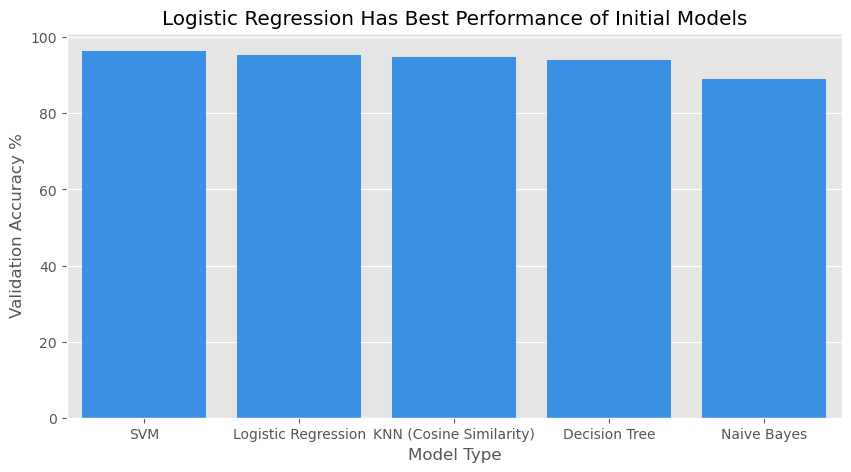

In [179]:
# Initialize the chart
plt.figure(figsize=(10,5))
# Create a bar plot from the validation accuracies in the results data frame
mod_perf_fig = sns.barplot(
    x='Model',
    y='Validation Accuracy',
    data=results_df.sort_values('Validation Accuracy', ascending=False),
    color='dodgerblue'
)
# Add a title and labels
plt.title('Logistic Regression Has Best Performance of Initial Models')
plt.xlabel('Model Type')
plt.ylabel('Validation Accuracy %')
# Display the chart
plt.show()

As demonstrated by the results table and chart, of the four models with no hyper-parameter optimization, the SVM model performs best with a validation accuracy of 96%.

In [180]:
# Save the chart
mod_perf_fig.figure.savefig('model_perf', bbox_inches="tight")

### TFIDF Vectorizer

The previous models had been trained and evaluated on data transformed by a count vectorizer. Since the count vectorizer does not take term frequency into account, it is possible that some words may be weighted too heavily especially if they are repeated multiple times in a single document. As such, the data will be transformed using a TFIDF vectorizer and the same simple models trained and evaluated using the data vectorized by the TFIDF vectorizer. In order to do this, the text content will need to be transformed using this TFIDF vectorizer.

In [181]:
# Instantiate column transformer with TFIDF vectorizer
tfidf_transf = ColumnTransformer([
        (
            # Name the transformation
            'tfidf_vectorizer',
            # Instantate the TFIDF vectorizer with the custom tokenizer and a minimum term frequency of 5%
            TfidfVectorizer(
                tokenizer=custom_tokenizer,
                min_df=0.05
            ),
            # Select the column to be transformed
            'content',
        )
    ],
    # Specify that all other columns should remain unchanged
    remainder='passthrough'
)

In [182]:
# Fit and transform the x training data with the TFIDF vectorizer
X_train_tfidf = tfidf_transf.fit_transform(X_train)

In [183]:
# Put the transformed x training data into a data frame
X_train_tfidf = pd.DataFrame(
    data=X_train_tfidf.toarray(),
    columns=cv_transf.get_feature_names_out(),
)
# Check the top 10 columns of the data frame
X_train_tfidf.head(10)

,count_vectorizer__abl,count_vectorizer__accept,count_vectorizer__access,count_vectorizer__accord,count_vectorizer__account,count_vectorizer__actual,count_vectorizer__address,count_vectorizer__agre,count_vectorizer__agreement,count_vectorizer__along,count_vectorizer__also,count_vectorizer__amount,count_vectorizer__anoth,count_vectorizer__arrang,count_vectorizer__ask,count_vectorizer__assist,count_vectorizer__assur,count_vectorizer__attent,count_vectorizer__back,count_vectorizer__bank,count_vectorizer__base,count_vectorizer__behalf,count_vectorizer__believ,count_vectorizer__beneficiari,count_vectorizer__best,count_vectorizer__bless,count_vectorizer__busi,count_vectorizer__call,count_vectorizer__care,count_vectorizer__case,count_vectorizer__chang,count_vectorizer__choos,count_vectorizer__claim,count_vectorizer__click,count_vectorizer__client,count_vectorizer__close,count_vectorizer__come,count_vectorizer__commun,count_vectorizer__compani,count_vectorizer__complet,count_vectorizer__concern,count_vectorizer__confid,count_vectorizer__confidenti,count_vectorizer__confirm,count_vectorizer__contact,count_vectorizer__corpor,count_vectorizer__could,count_vectorizer__countri,count_vectorizer__cours,count_vectorizer__current,count_vectorizer__custom,count_vectorizer__day,count_vectorizer__deal,count_vectorizer__dear,count_vectorizer__death,count_vectorizer__deceas,count_vectorizer__decid,count_vectorizer__depart,count_vectorizer__deposit,count_vectorizer__develop,count_vectorizer__direct,count_vectorizer__discov,count_vectorizer__discuss,count_vectorizer__done,count_vectorizer__due,count_vectorizer__easi,count_vectorizer__enabl,count_vectorizer__end,count_vectorizer__even,count_vectorizer__everi,count_vectorizer__execut,count_vectorizer__fact,count_vectorizer__faith,count_vectorizer__famili,count_vectorizer__father,count_vectorizer__file,count_vectorizer__final,count_vectorizer__financi,count_vectorizer__find,count_vectorizer__first,count_vectorizer__five,count_vectorizer__follow,count_vectorizer__foreign,count_vectorizer__form,count_vectorizer__former,count_vectorizer__forward,count_vectorizer__free,count_vectorizer__friend,count_vectorizer__full,count_vectorizer__fund,count_vectorizer__futur,count_vectorizer__gener,count_vectorizer__get,count_vectorizer__give,count_vectorizer__given,count_vectorizer__go,count_vectorizer__god,count_vectorizer__good,count_vectorizer__got,count_vectorizer__govern,count_vectorizer__great,count_vectorizer__group,count_vectorizer__hear,count_vectorizer__help,count_vectorizer__henc,count_vectorizer__home,count_vectorizer__hope,count_vectorizer__hous,count_vectorizer__howev,count_vectorizer__hundr,count_vectorizer__id,count_vectorizer__immedi,count_vectorizer__import,count_vectorizer__includ,count_vectorizer__inform,count_vectorizer__interest,count_vectorizer__intern,count_vectorizer__invest,count_vectorizer__involv,count_vectorizer__issu,count_vectorizer__keep,count_vectorizer__kin,count_vectorizer__know,count_vectorizer__last,count_vectorizer__late,count_vectorizer__law,count_vectorizer__leav,count_vectorizer__left,count_vectorizer__legal,count_vectorizer__let,count_vectorizer__letter,count_vectorizer__life,count_vectorizer__like,count_vectorizer__link,count_vectorizer__list,count_vectorizer__live,count_vectorizer__long,count_vectorizer__look,count_vectorizer__made,count_vectorizer__mail,count_vectorizer__mailman,count_vectorizer__make,count_vectorizer__manag,count_vectorizer__mani,count_vectorizer__matter,count_vectorizer__may,count_vectorizer__meet,count_vectorizer__member,count_vectorizer__messag,count_vectorizer__might,count_vectorizer__million,count_vectorizer__money,count_vectorizer__move,count_vectorizer__much,count_vectorizer__must,count_vectorizer__name,count_vectorizer__nation,count_vectorizer__necessari,count_vectorizer__need,count_vectorizer__net,count_vectorizer__never,count_vectorizer__new,count_vectorizer__next,count_vectorizer__note,count_vectorizer__number,count_vectorizer__offer,count_vector

In [184]:
# Check the shape of the data
X_train_tfidf.shape

(7936, 283)

In [185]:
# Transform the validation data using the fitted TFIDF vectorizer
X_validation_tfidf = cv_transf.transform(X_validation)
# Put the validation data into a data frame
X_validation_tfidf = pd.DataFrame(
    data=X_validation_tfidf.toarray(),
    columns=cv_transf.get_feature_names_out(),
)
# Look at the top 10 columns from the validation data frame
X_validation_tfidf.head(10)

,count_vectorizer__abl,count_vectorizer__accept,count_vectorizer__access,count_vectorizer__accord,count_vectorizer__account,count_vectorizer__actual,count_vectorizer__address,count_vectorizer__agre,count_vectorizer__agreement,count_vectorizer__along,count_vectorizer__also,count_vectorizer__amount,count_vectorizer__anoth,count_vectorizer__arrang,count_vectorizer__ask,count_vectorizer__assist,count_vectorizer__assur,count_vectorizer__attent,count_vectorizer__back,count_vectorizer__bank,count_vectorizer__base,count_vectorizer__behalf,count_vectorizer__believ,count_vectorizer__beneficiari,count_vectorizer__best,count_vectorizer__bless,count_vectorizer__busi,count_vectorizer__call,count_vectorizer__care,count_vectorizer__case,count_vectorizer__chang,count_vectorizer__choos,count_vectorizer__claim,count_vectorizer__click,count_vectorizer__client,count_vectorizer__close,count_vectorizer__come,count_vectorizer__commun,count_vectorizer__compani,count_vectorizer__complet,count_vectorizer__concern,count_vectorizer__confid,count_vectorizer__confidenti,count_vectorizer__confirm,count_vectorizer__contact,count_vectorizer__corpor,count_vectorizer__could,count_vectorizer__countri,count_vectorizer__cours,count_vectorizer__current,count_vectorizer__custom,count_vectorizer__day,count_vectorizer__deal,count_vectorizer__dear,count_vectorizer__death,count_vectorizer__deceas,count_vectorizer__decid,count_vectorizer__depart,count_vectorizer__deposit,count_vectorizer__develop,count_vectorizer__direct,count_vectorizer__discov,count_vectorizer__discuss,count_vectorizer__done,count_vectorizer__due,count_vectorizer__easi,count_vectorizer__enabl,count_vectorizer__end,count_vectorizer__even,count_vectorizer__everi,count_vectorizer__execut,count_vectorizer__fact,count_vectorizer__faith,count_vectorizer__famili,count_vectorizer__father,count_vectorizer__file,count_vectorizer__final,count_vectorizer__financi,count_vectorizer__find,count_vectorizer__first,count_vectorizer__five,count_vectorizer__follow,count_vectorizer__foreign,count_vectorizer__form,count_vectorizer__former,count_vectorizer__forward,count_vectorizer__free,count_vectorizer__friend,count_vectorizer__full,count_vectorizer__fund,count_vectorizer__futur,count_vectorizer__gener,count_vectorizer__get,count_vectorizer__give,count_vectorizer__given,count_vectorizer__go,count_vectorizer__god,count_vectorizer__good,count_vectorizer__got,count_vectorizer__govern,count_vectorizer__great,count_vectorizer__group,count_vectorizer__hear,count_vectorizer__help,count_vectorizer__henc,count_vectorizer__home,count_vectorizer__hope,count_vectorizer__hous,count_vectorizer__howev,count_vectorizer__hundr,count_vectorizer__id,count_vectorizer__immedi,count_vectorizer__import,count_vectorizer__includ,count_vectorizer__inform,count_vectorizer__interest,count_vectorizer__intern,count_vectorizer__invest,count_vectorizer__involv,count_vectorizer__issu,count_vectorizer__keep,count_vectorizer__kin,count_vectorizer__know,count_vectorizer__last,count_vectorizer__late,count_vectorizer__law,count_vectorizer__leav,count_vectorizer__left,count_vectorizer__legal,count_vectorizer__let,count_vectorizer__letter,count_vectorizer__life,count_vectorizer__like,count_vectorizer__link,count_vectorizer__list,count_vectorizer__live,count_vectorizer__long,count_vectorizer__look,count_vectorizer__made,count_vectorizer__mail,count_vectorizer__mailman,count_vectorizer__make,count_vectorizer__manag,count_vectorizer__mani,count_vectorizer__matter,count_vectorizer__may,count_vectorizer__meet,count_vectorizer__member,count_vectorizer__messag,count_vectorizer__might,count_vectorizer__million,count_vectorizer__money,count_vectorizer__move,count_vectorizer__much,count_vectorizer__must,count_vectorizer__name,count_vectorizer__nation,count_vectorizer__necessari,count_vectorizer__need,count_vectorizer__net,count_vectorizer__never,count_vectorizer__new,count_vectorizer__next,count_vectorizer__note,count_vectorizer__number,count_vectorizer__offer,count_vector

In [186]:
# Check the shape of the validation data
X_validation_tfidf.shape

(1984, 283)

### TFIDF Logistic Regression

Now that the training and validation data has been transformed with the TFIDF vectorize, the simple models can be fit and evaluated using this data.

In [187]:
# Initialize TFIDF results dictionary
tfidf_results_dict = {
    'Model': [],
    'Train Accuracy': [],
    'Validation Accuracy': [],
}

In [188]:
# Get PCA version of X_train and X_val
pca_tranformer = PCA(n_components=10)
X_train_tfidf_pca = pca_tranformer.fit_transform(X_train_tfidf)
X_val_tfidf_pca = pca_tranformer.transform(X_validation_tfidf)

In [189]:
# Instantiate the logistic regression model
log_reg_model_tfidf_pca = LogisticRegression()
# Fit the logistic regression model
log_reg_model_tfidf_pca.fit(X_train_tfidf_pca, y_train)
# Display the train accuracy of the logistic regression model
train_acc_log_tfidf_pca = log_reg_model_tfidf_pca.score(X_train_tfidf_pca, y_train) * 100
print(train_acc_log_tfidf_pca)

95.19909274193549


In [190]:
# Display the validation accuracy of the logistic regression model
val_acc_log_tfidf = log_reg_model_tfidf_pca.score(X_val_tfidf_pca, y_validation) * 100
print(val_acc_log_tfidf)

87.90322580645162


In [191]:
# Append the results to the results dictionary
tfidf_results_dict['Model'].append('Logistic Regression')
tfidf_results_dict['Train Accuracy'].append(train_acc_log_tfidf_pca)
tfidf_results_dict['Validation Accuracy'].append(val_acc_log_tfidf)

At first glance, it seems the accuracy of a default logistic regression using the TFIDF vectorized features is lower on both the train and validation scores than the logistic regression trained on the count vectorized features. However, the results of the TFIDF vectorized content will be compared using the other models to establish whether TFIDF should be used or not.

### TFIDF SVM

The next model that will be evaluated is a SVM model using standard settings. For this model, we will use a standard scaler on the feature data

In [192]:
# Initialize scaler
standardScalerTFIDF = StandardScaler()
# Fit the scaler on the train data
standardScalerTFIDF.fit(X_train_tfidf)
# Transform the train data
x_tfidf_ss_scaled_vec = standardScalerTFIDF.transform(X_train_tfidf)
# Instantiate and fit the KNN model with cosine similarity
svc_tfidf_model = SVC()
svc_tfidf_model.fit(x_tfidf_ss_scaled_vec, y_train)
# Get the train % accuracy and print it
svc_tfidf_train_acc = svc_tfidf_model.score(x_tfidf_ss_scaled_vec, y_train) * 100
print(svc_tfidf_train_acc)

99.21875


In [193]:
# Scale the validation data set using the fitted scaler
x_val_tfidf_ss_scaled_vec = standardScalerTFIDF.transform(X_validation_tfidf)
svc_tfidf_val_acc = svc_tfidf_model.score(x_val_tfidf_ss_scaled_vec, y_validation) * 100
print(svc_tfidf_val_acc)

54.5866935483871


In [194]:
# Append the results of the KNN model to the results dictionary
tfidf_results_dict['Model'].append('SVM')
tfidf_results_dict['Train Accuracy'].append(svc_tfidf_train_acc)
tfidf_results_dict['Validation Accuracy'].append(svc_tfidf_val_acc)

Although the train accuracy for the TFIDF model is very high with a value of 99% it appears the validation accuracy is much lower with a value at 55%. This indicates that TFIDF may cause the SVM model to over fit to the training data and not improve performance.

### TFIDF KNN

Next the result of KNN with TFIDF vectorized content will be evaluated.

In [195]:
minMaxScaler = MinMaxScaler()
minMaxScaler.fit(X_train_tfidf)
x_mm_scaled_tfidf = minMaxScaler.transform(X_train_tfidf)
knn_model_tfidf = KNeighborsClassifier(n_neighbors=5, metric='cosine')
knn_model_tfidf.fit(x_mm_scaled_tfidf, y_train)
knn_tfidf_train_acc = knn_model_tfidf.score(x_mm_scaled_tfidf, y_train) * 100
print(knn_tfidf_train_acc)

97.60584677419355


In [196]:
x_mm_scaled_tfidf = minMaxScaler.transform(X_validation_vec)
knn_tfidf_val_acc = knn_model.score(x_mm_scaled_tfidf, y_validation) * 100
print(knn_tfidf_val_acc)

95.16129032258065


In [197]:
# Append the results of the KNN model to the results dictionary
tfidf_results_dict['Model'].append('KNN (Cosine Similarity)')
tfidf_results_dict['Train Accuracy'].append(knn_tfidf_train_acc)
tfidf_results_dict['Validation Accuracy'].append(knn_tfidf_val_acc)

Compared to the count vectorized features, KNN using the TFIDF vectorized features improved both the train and validation accuracy slightly.

### TFIDF Decision Tree

The accuracy for the decision tree using the TFIDF vectorized features will be evaluated.

In [198]:
tfidf_dec_tree_model = DecisionTreeClassifier()
tfidf_dec_tree_model.fit(X_train_tfidf, y_train)
tfidf_dec_train_acc = tfidf_dec_tree_model.score(X_train_tfidf, y_train) * 100
print(tfidf_dec_train_acc)

99.92439516129032


In [199]:
tfidf_dec_val_acc = tfidf_dec_tree_model.score(X_validation_tfidf, y_validation) * 100
print(tfidf_dec_val_acc)

69.25403225806451


In [200]:
# Append the results of the KNN model to the results dictionary
tfidf_results_dict['Model'].append('Decision Tree')
tfidf_results_dict['Train Accuracy'].append(tfidf_dec_train_acc)
tfidf_results_dict['Validation Accuracy'].append(tfidf_dec_val_acc)

The accuracy result for the train set is similar to that of the count vectorized trained decision tree model, however the accuracy for the validation set is much worse at 69%.

### TFIDF Naive Bayes

Lastly, the Naive Bayes model will be trained on the TFIDF vectorized features and accuracy compared.

In [201]:
# Instantiate the model
tfidf_nb_model = BernoulliNB()
# Train the model
tfidf_nb_model.fit(X_train_vec, y_train)
# Get the model % accuracy of the model on the train data set
tfidf_nb_train_acc = nb_model.score(X_train_vec, y_train) * 100
print(tfidf_nb_train_acc)

89.33971774193549


In [202]:
# Get the model % accuracy on the validation data set
tfidf_nb_val_acc = nb_model.score(X_validation_vec, y_validation) * 100
print(tfidf_nb_val_acc)

88.91129032258065


In [203]:
# Append the results to the results dictionary
tfidf_results_dict['Model'].append('Naive Bayes')
tfidf_results_dict['Train Accuracy'].append(tfidf_nb_train_acc)
tfidf_results_dict['Validation Accuracy'].append(tfidf_nb_val_acc)

The results for the Naive Bayes model for the TFIDF vectorized features appears to be the very similar to the results for the Count Vectorized content.

### Comparing TFIDF and Count Vectorized Results

The results of the TFIDF vectorized and count vectorized will be plotted for a direct comparison.

In [204]:
# Create a data frame from the results dictionary
tfidf_results_df = pd.DataFrame(tfidf_results_dict)

In [205]:
# View the results data frame
tfidf_results_df

,Model,Train Accuracy,Validation Accuracy
0,Logistic Regression,95.199093,87.903226
1,SVM,99.218750,54.586694
2,KNN (Cosine Similarity),97.605847,95.161290
3,Decision Tree,99.924395,69.254032
4,Naive Bayes,89.339718,88.911290


In [206]:
# Add identifier for TFIDF vectorized content
tfidf_results_df['Vectorizer'] = 'TFIDF'

In [207]:
# Add identifier for Count vectorized content
results_df['Vectorizer'] = 'Count'

In [208]:
# Combined the results DFs
combined_results_df = pd.concat([results_df, tfidf_results_df])

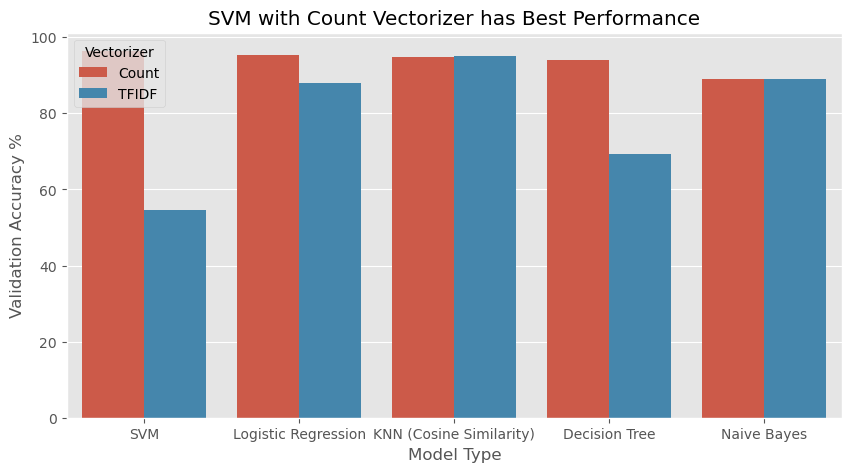

In [210]:
# Initialize the chart
plt.figure(figsize=(10,5))
# Create a bar plot from the validation accuracies in the results data frame
mod_perf_fig = sns.barplot(
    x='Model',
    y='Validation Accuracy',
    hue='Vectorizer',
    data=combined_results_df.sort_values('Validation Accuracy', ascending=False),
)
# Add a title and labels
plt.title('SVM with Count Vectorizer has Best Performance')
plt.xlabel('Model Type')
plt.ylabel('Validation Accuracy %')
# Display the chart
plt.show()

As demonstrated by the above chart, TFIDF did not improve performance for any models with the exception of KNN, which was still outperformed by SVM trained using a Count Vectorizer. Given this, all models except the KNN model will be trained on content vectorized using the count vectorizer instead of the TFIDF vectorizer.

In [211]:
# Save the chart
mod_perf_fig.figure.savefig('./img/model_performance', bbox_inches="tight")

### Build Test Pipelines

Now that we have established some initial accuracy results with unoptimized models, these models should be tested and accuracies evaluated with some hyperparameter tuning. This grid search will utilize 5-fold cross validation and F1 scoring will be used as the primary method of evaluation as this represents a balance between precision and recall. The secondary scoring metric will be recall as for the purposes of fraud identification, it is better to have a false positive result than a false negative one.

In [88]:
# Set up temporary directory for pipeline cache
cachedir = mkdtemp()
# Initialize pipeline with count vectorizer, scaler and modelling stages
mod_pipeline = Pipeline([
        ('vectorize', cv_transf),
        ('pca', PCA()),
        ('scaler', StandardScaler()),
        ('model', LogisticRegression())
    ],
    # Set the cache the the temp cache directory
    memory=cachedir
)

In [214]:
# Initialize the C values to be used to optimize the regularization strength of logistic regression
c_range = [10**i for i in range(-3, 4)]

# Initialize the parameter grid for use with the grid search for hyperparameter optimization
grid_search_param_grid = [
    # Set up hyperparameter optimization for Logistic Regression model
    {
        # Use standard and minmax scalers
        'scaler': [None, StandardScaler(), MinMaxScaler()],
        # Add PCA for logistic regression
        'pca': [PCA()],
        # Set the number of components for use with PCA
        'pca__n_components': [10, 20],
        # Set model to be used as Logistic Regression
        'model': [LogisticRegression()],
        # Set C values for use with Logistic Regression
        'model__C': c_range, # Set regularization strength coefficients
        # Adjust penalties used with Logistic Regression
        'model__penalty': ['l1', 'l2', 'elasticnet'],
        # Set solvers to be used with Logistic Regression
        'model__solver': ['lbfgs', 'liblinear'],

    },
    # Set up hyperparameter optimization for SVM model
    {
        # Use Count Vectorizer
        'vectorize': [cv_transf],
        # PCA is set to none since it is not required
        'pca': [None],
        # Use standard and minmax scalers
        'scaler': [StandardScaler(), MinMaxScaler()],
        # Set up model to be used as SVM
        'model': [SVC()],
        # Set C values for use with SVM
        'model__C': c_range, # Set regularization strength coefficients
        # Set the different SVM kernels for use with the model
        'model__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
        # Set the different gamma options for SVM
        'model__gamma': ['scale', 'auto'],
    },
    # Set up hyperparameter optimization for KNN model
    {
        # Use TFIDF and Count Vectorizers
        'vectorize': [cv_transf, tfidf_transf],
        # PCA is set to none since it is not required
        'pca': [None],
        # Use standard and minmax scalers
        'scaler': [StandardScaler(), MinMaxScaler()],
        # Set up model to be used as KNN
        'model': [KNeighborsClassifier()],
        # Set up range of neighbors to use with KNN
        'model__n_neighbors': range(5, 51, 5),
        # Set the different distances used to measure KNN distance
        'model__metric':['minkowski', 'cosine'],
    },
    # Set up hyperparameter optimization with Decision Tree classifier
    {
        # No scaler is necessary for Decision Tree classifiers to set to none
        'scaler': [None],
        # PCA is set to none since it is not required
        'pca': [None],
        # Set model to be used as decision tree classifier
        'model': [DecisionTreeClassifier()],
        # Set max model depth
        'model__max_depth': range(3, 21, 2),
    },
    # Set up hyperparameter optimization with Naive Bayes model
    {
        # No scaler necessary for Naive Bayes
        'scaler': [None],
        # PCA is set to none since it is not required
        'pca': [None],
        # Set model to be naive bayes
        'model': [BernoulliNB()],
        # Adjust the laplace smoothing parameter for Naive Bayes
        'model__alpha': range(0, 100, 10),
        
    }
]

# Initialize grid search to optimize hyperparameters
basic_model_cv = GridSearchCV(
    # Set pipeline to be run for the grid search
    estimator=mod_pipeline,
    # Set the number of cross validation folds to be used
    cv=5,
    # Initialize the parameter grid
    param_grid=grid_search_param_grid,
    # Set the model evaluation to use F1 scoring
    scoring=['f1', 'recall'],
    # Set the grid to output statements for each grid search run
    verbose=2,
    # Set refit value to recall indicating this as the deciding factor
    refit='recall',
)

In [215]:
# Fit the grid search
basic_model_cv.fit(X_remainder, y_remainder)

Fitting 5 folds for each of 463 candidates, totalling 2315 fits
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=l1, model__solver=lbfgs, pca=PCA(), pca__n_components=10, scaler=None; total time=  10.8s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=l1, model__solver=lbfgs, pca=PCA(), pca__n_components=10, scaler=None; total time=  10.8s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=l1, model__solver=lbfgs, pca=PCA(), pca__n_components=10, scaler=None; total time=  10.9s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=l1, model__solver=lbfgs, pca=PCA(), pca__n_components=10, scaler=None; total time=  10.7s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=l1, model__solver=lbfgs, pca=PCA(), pca__n_components=10, scaler=None; total time=  10.7s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=l1, model__solver=lbfgs, pca=PCA(), pca__n_components=10, scaler=StandardScale

[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=l1, model__solver=liblinear, pca=PCA(), pca__n_components=20, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=l1, model__solver=liblinear, pca=PCA(), pca__n_components=20, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=l1, model__solver=liblinear, pca=PCA(), pca__n_components=20, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=l1, model__solver=liblinear, pca=PCA(), pca__n_components=20, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=l1, model__solver=liblinear, pca=PCA(), pca__n_components=20, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=l1, model__solver=liblinear, pca=PCA(), pca__n_components=20, sc

[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=l2, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=l2, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=l2, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=l2, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=l2, model__solver=liblinear, pca=PCA(), pca__n_components=20, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=l2, model__solver=liblinear, pca=PCA(), pca__n_components=20, scaler=None; total t

[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=elasticnet, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=elasticnet, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=elasticnet, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=elasticnet, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=elasticnet, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=elasticnet, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=Stand

[CV] END model=LogisticRegression(), model__C=0.01, model__penalty=l1, model__solver=lbfgs, pca=PCA(), pca__n_components=20, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.01, model__penalty=l1, model__solver=lbfgs, pca=PCA(), pca__n_components=20, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.01, model__penalty=l1, model__solver=lbfgs, pca=PCA(), pca__n_components=20, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.01, model__penalty=l1, model__solver=lbfgs, pca=PCA(), pca__n_components=20, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.01, model__penalty=l1, model__solver=lbfgs, pca=PCA(), pca__n_components=20, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.01, model__penalty=l1, model__solver=lbfgs, pca=PCA(), pca__n_components=20, scaler=StandardScaler(); total time=   0.1s
[CV] END m

[CV] END model=LogisticRegression(), model__C=0.01, model__penalty=l2, model__solver=lbfgs, pca=PCA(), pca__n_components=10, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.01, model__penalty=l2, model__solver=lbfgs, pca=PCA(), pca__n_components=10, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.01, model__penalty=l2, model__solver=lbfgs, pca=PCA(), pca__n_components=10, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.01, model__penalty=l2, model__solver=lbfgs, pca=PCA(), pca__n_components=10, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.01, model__penalty=l2, model__solver=lbfgs, pca=PCA(), pca__n_components=10, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.01, model__penalty=l2, model__solver=lbfgs, pca=PCA(), pca__n_components=20, scaler=None; total time=   0.1s
[CV] END

[CV] END model=LogisticRegression(), model__C=0.01, model__penalty=elasticnet, model__solver=lbfgs, pca=PCA(), pca__n_components=10, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.01, model__penalty=elasticnet, model__solver=lbfgs, pca=PCA(), pca__n_components=10, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.01, model__penalty=elasticnet, model__solver=lbfgs, pca=PCA(), pca__n_components=10, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.01, model__penalty=elasticnet, model__solver=lbfgs, pca=PCA(), pca__n_components=10, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.01, model__penalty=elasticnet, model__solver=lbfgs, pca=PCA(), pca__n_components=10, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.01, model__penalty=elasticnet, model__solver=lbfgs, pca=PCA(), pca__n_components=10, scaler=StandardSca

[CV] END model=LogisticRegression(), model__C=0.01, model__penalty=elasticnet, model__solver=liblinear, pca=PCA(), pca__n_components=20, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.01, model__penalty=elasticnet, model__solver=liblinear, pca=PCA(), pca__n_components=20, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.01, model__penalty=elasticnet, model__solver=liblinear, pca=PCA(), pca__n_components=20, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.01, model__penalty=elasticnet, model__solver=liblinear, pca=PCA(), pca__n_components=20, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.01, model__penalty=elasticnet, model__solver=liblinear, pca=PCA(), pca__n_components=20, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.01, model__penalty=elasticnet, model__solver=li

[CV] END model=LogisticRegression(), model__C=0.1, model__penalty=l1, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.1, model__penalty=l1, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.1, model__penalty=l1, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.1, model__penalty=l1, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.1, model__penalty=l1, model__solver=liblinear, pca=PCA(), pca__n_components=20, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.1, model__penalty=l1, model__solver=liblinear, pca=PCA(), pca__n_components=20, scaler=None; total time=   0.1s


[CV] END model=LogisticRegression(), model__C=0.1, model__penalty=l2, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.1, model__penalty=l2, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.1, model__penalty=l2, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.1, model__penalty=l2, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.1, model__penalty=l2, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.1, model__penalty=l2, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=StandardScaler(); total time=

[CV] END model=LogisticRegression(), model__C=0.1, model__penalty=elasticnet, model__solver=lbfgs, pca=PCA(), pca__n_components=20, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.1, model__penalty=elasticnet, model__solver=lbfgs, pca=PCA(), pca__n_components=20, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.1, model__penalty=elasticnet, model__solver=lbfgs, pca=PCA(), pca__n_components=20, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.1, model__penalty=elasticnet, model__solver=lbfgs, pca=PCA(), pca__n_components=20, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.1, model__penalty=elasticnet, model__solver=lbfgs, pca=PCA(), pca__n_components=20, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.1, model__penalty=elasticnet, model__solver=liblinear, pca=PCA(), pca__n_component

[CV] END model=LogisticRegression(), model__C=1, model__penalty=l1, model__solver=lbfgs, pca=PCA(), pca__n_components=10, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1, model__penalty=l1, model__solver=lbfgs, pca=PCA(), pca__n_components=10, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1, model__penalty=l1, model__solver=lbfgs, pca=PCA(), pca__n_components=20, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1, model__penalty=l1, model__solver=lbfgs, pca=PCA(), pca__n_components=20, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1, model__penalty=l1, model__solver=lbfgs, pca=PCA(), pca__n_components=20, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1, model__penalty=l1, model__solver=lbfgs, pca=PCA(), pca__n_components=20, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1, model__

[CV] END model=LogisticRegression(), model__C=1, model__penalty=l2, model__solver=lbfgs, pca=PCA(), pca__n_components=10, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1, model__penalty=l2, model__solver=lbfgs, pca=PCA(), pca__n_components=10, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1, model__penalty=l2, model__solver=lbfgs, pca=PCA(), pca__n_components=10, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1, model__penalty=l2, model__solver=lbfgs, pca=PCA(), pca__n_components=10, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1, model__penalty=l2, model__solver=lbfgs, pca=PCA(), pca__n_components=10, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1, model__penalty=l2, model__solver=lbfgs, pca=PCA(), pca__n_components=10, scaler=MinMaxScaler(); total time=   0.1s
[CV] E

[CV] END model=LogisticRegression(), model__C=1, model__penalty=l2, model__solver=liblinear, pca=PCA(), pca__n_components=20, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1, model__penalty=l2, model__solver=liblinear, pca=PCA(), pca__n_components=20, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1, model__penalty=l2, model__solver=liblinear, pca=PCA(), pca__n_components=20, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1, model__penalty=elasticnet, model__solver=lbfgs, pca=PCA(), pca__n_components=10, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1, model__penalty=elasticnet, model__solver=lbfgs, pca=PCA(), pca__n_components=10, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1, model__penalty=elasticnet, model__solver=lbfgs, pca=PCA(), pca__n_components=10, scaler=None; total time=   0.1s
[CV] END m

[CV] END model=LogisticRegression(), model__C=1, model__penalty=elasticnet, model__solver=liblinear, pca=PCA(), pca__n_components=20, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1, model__penalty=elasticnet, model__solver=liblinear, pca=PCA(), pca__n_components=20, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1, model__penalty=elasticnet, model__solver=liblinear, pca=PCA(), pca__n_components=20, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1, model__penalty=elasticnet, model__solver=liblinear, pca=PCA(), pca__n_components=20, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1, model__penalty=elasticnet, model__solver=liblinear, pca=PCA(), pca__n_components=20, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1, model__penalty=elasticnet, model__solver=liblinear, pca=PCA(), pca__n_com

[CV] END model=LogisticRegression(), model__C=10, model__penalty=l1, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=10, model__penalty=l1, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=10, model__penalty=l1, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=10, model__penalty=l1, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=10, model__penalty=l1, model__solver=liblinear, pca=PCA(), pca__n_components=20, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=10, model__penalty=l1, model__solver=liblinear, pca=PCA(), pca__n_components=20, scaler=None; total time=   0.1s
[CV] E

[CV] END model=LogisticRegression(), model__C=10, model__penalty=l2, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=10, model__penalty=l2, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=10, model__penalty=l2, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=10, model__penalty=l2, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=10, model__penalty=l2, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=10, model__penalty=l2, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=StandardScaler(); total time=   0.1

[CV] END model=LogisticRegression(), model__C=10, model__penalty=elasticnet, model__solver=lbfgs, pca=PCA(), pca__n_components=20, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=10, model__penalty=elasticnet, model__solver=lbfgs, pca=PCA(), pca__n_components=20, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=10, model__penalty=elasticnet, model__solver=lbfgs, pca=PCA(), pca__n_components=20, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=10, model__penalty=elasticnet, model__solver=lbfgs, pca=PCA(), pca__n_components=20, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=10, model__penalty=elasticnet, model__solver=lbfgs, pca=PCA(), pca__n_components=20, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=10, model__penalty=elasticnet, model__solver=liblinear, pca=PCA(), pca__n_components=10, 

[CV] END model=LogisticRegression(), model__C=100, model__penalty=l1, model__solver=lbfgs, pca=PCA(), pca__n_components=10, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=100, model__penalty=l1, model__solver=lbfgs, pca=PCA(), pca__n_components=10, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=100, model__penalty=l1, model__solver=lbfgs, pca=PCA(), pca__n_components=20, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=100, model__penalty=l1, model__solver=lbfgs, pca=PCA(), pca__n_components=20, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=100, model__penalty=l1, model__solver=lbfgs, pca=PCA(), pca__n_components=20, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=100, model__penalty=l1, model__solver=lbfgs, pca=PCA(), pca__n_components=20, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__

[CV] END model=LogisticRegression(), model__C=100, model__penalty=l2, model__solver=lbfgs, pca=PCA(), pca__n_components=10, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=100, model__penalty=l2, model__solver=lbfgs, pca=PCA(), pca__n_components=10, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=100, model__penalty=l2, model__solver=lbfgs, pca=PCA(), pca__n_components=10, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=100, model__penalty=l2, model__solver=lbfgs, pca=PCA(), pca__n_components=10, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=100, model__penalty=l2, model__solver=lbfgs, pca=PCA(), pca__n_components=10, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=100, model__penalty=l2, model__solver=lbfgs, pca=PCA(), pca__n_components=10, scaler=MinMaxScaler(); total time=  

[CV] END model=LogisticRegression(), model__C=100, model__penalty=l2, model__solver=liblinear, pca=PCA(), pca__n_components=20, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=100, model__penalty=l2, model__solver=liblinear, pca=PCA(), pca__n_components=20, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=100, model__penalty=l2, model__solver=liblinear, pca=PCA(), pca__n_components=20, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=100, model__penalty=elasticnet, model__solver=lbfgs, pca=PCA(), pca__n_components=10, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=100, model__penalty=elasticnet, model__solver=lbfgs, pca=PCA(), pca__n_components=10, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=100, model__penalty=elasticnet, model__solver=lbfgs, pca=PCA(), pca__n_components=10, scaler=None; total time=   0.1

[CV] END model=LogisticRegression(), model__C=100, model__penalty=elasticnet, model__solver=liblinear, pca=PCA(), pca__n_components=20, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=100, model__penalty=elasticnet, model__solver=liblinear, pca=PCA(), pca__n_components=20, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=100, model__penalty=elasticnet, model__solver=liblinear, pca=PCA(), pca__n_components=20, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=100, model__penalty=elasticnet, model__solver=liblinear, pca=PCA(), pca__n_components=20, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=100, model__penalty=elasticnet, model__solver=liblinear, pca=PCA(), pca__n_components=20, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=100, model__penalty=elasticnet, model__solver=liblinear, pca=PCA(), pca__n_components=20, scaler=StandardScaler();

[CV] END model=LogisticRegression(), model__C=1000, model__penalty=l1, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1000, model__penalty=l1, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1000, model__penalty=l1, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1000, model__penalty=l1, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1000, model__penalty=l1, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1000, model__penalty=l1, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=Min

[CV] END model=LogisticRegression(), model__C=1000, model__penalty=l2, model__solver=lbfgs, pca=PCA(), pca__n_components=20, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1000, model__penalty=l2, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1000, model__penalty=l2, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1000, model__penalty=l2, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1000, model__penalty=l2, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1000, model__penalty=l2, model__solver=liblinear, pca=PCA(), pca__n_components=10, scaler=None; total time=   0.1s
[CV] END model=LogisticRegre

[CV] END model=LogisticRegression(), model__C=1000, model__penalty=elasticnet, model__solver=lbfgs, pca=PCA(), pca__n_components=20, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1000, model__penalty=elasticnet, model__solver=lbfgs, pca=PCA(), pca__n_components=20, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1000, model__penalty=elasticnet, model__solver=lbfgs, pca=PCA(), pca__n_components=20, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1000, model__penalty=elasticnet, model__solver=lbfgs, pca=PCA(), pca__n_components=20, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1000, model__penalty=elasticnet, model__solver=lbfgs, pca=PCA(), pca__n_components=20, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1000, model__penalty=elasticnet, model__solver=lbfgs, pca=PCA(), pca__n

[CV] END model=SVC(), model__C=0.001, model__gamma=scale, model__kernel=linear, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=0.001, model__gamma=scale, model__kernel=linear, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=0.001, model__gamma=scale, model__kernel=linear, pca=None, sc

[CV] END model=SVC(), model__C=0.001, model__gamma=scale, model__kernel=rbf, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=0.001, model__gamma=scale, model__kernel=rbf, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=0.001, model__gamma=scale, model__kernel=rbf, pca=None, scaler=MinM

[CV] END model=SVC(), model__C=0.001, model__gamma=auto, model__kernel=linear, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=0.001, model__gamma=auto, model__kernel=linear, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=0.001, model__gamma=auto, model__kernel=linear, pca=None, scale

[CV] END model=SVC(), model__C=0.001, model__gamma=auto, model__kernel=rbf, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=0.001, model__gamma=auto, model__kernel=rbf, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=0.001, model__gamma=auto, model__kernel=rbf, pca=None, scaler=MinMaxS

[CV] END model=SVC(), model__C=0.01, model__gamma=scale, model__kernel=linear, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=0.01, model__gamma=scale, model__kernel=linear, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=0.01, model__gamma=scale, model__kernel=linear, pca=None, scale

[CV] END model=SVC(), model__C=0.01, model__gamma=scale, model__kernel=rbf, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=0.01, model__gamma=scale, model__kernel=rbf, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=0.01, model__gamma=scale, model__kernel=rbf, pca=None, scaler=MinMaxS

[CV] END model=SVC(), model__C=0.01, model__gamma=auto, model__kernel=linear, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=0.01, model__gamma=auto, model__kernel=linear, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=0.01, model__gamma=auto, model__kernel=linear, pca=None, scaler=M

[CV] END model=SVC(), model__C=0.01, model__gamma=auto, model__kernel=rbf, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=0.01, model__gamma=auto, model__kernel=rbf, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=0.01, model__gamma=auto, model__kernel=rbf, pca=None, scaler=MinMaxScal

[CV] END model=SVC(), model__C=0.1, model__gamma=scale, model__kernel=linear, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=0.1, model__gamma=scale, model__kernel=linear, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=0.1, model__gamma=scale, model__kernel=linear, pca=None, scaler=M

[CV] END model=SVC(), model__C=0.1, model__gamma=scale, model__kernel=rbf, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=0.1, model__gamma=scale, model__kernel=rbf, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=0.1, model__gamma=scale, model__kernel=rbf, pca=None, scaler=MinMaxScal

[CV] END model=SVC(), model__C=0.1, model__gamma=auto, model__kernel=linear, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=0.1, model__gamma=auto, model__kernel=linear, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=0.1, model__gamma=auto, model__kernel=linear, pca=None, scaler=MinM

[CV] END model=SVC(), model__C=0.1, model__gamma=auto, model__kernel=rbf, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=0.1, model__gamma=auto, model__kernel=rbf, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=0.1, model__gamma=auto, model__kernel=rbf, pca=None, scaler=MinMaxScaler(

[CV] END model=SVC(), model__C=1, model__gamma=scale, model__kernel=linear, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=1, model__gamma=scale, model__kernel=linear, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=1, model__gamma=scale, model__kernel=linear, pca=None, scaler=MinMaxS

[CV] END model=SVC(), model__C=1, model__gamma=scale, model__kernel=rbf, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=1, model__gamma=scale, model__kernel=rbf, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=1, model__gamma=scale, model__kernel=rbf, pca=None, scaler=MinMaxScaler(), 

[CV] END model=SVC(), model__C=1, model__gamma=auto, model__kernel=linear, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=1, model__gamma=auto, model__kernel=linear, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=1, model__gamma=auto, model__kernel=linear, pca=None, scaler=MinMaxScal

[CV] END model=SVC(), model__C=1, model__gamma=auto, model__kernel=rbf, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=1, model__gamma=auto, model__kernel=rbf, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=1, model__gamma=auto, model__kernel=rbf, pca=None, scaler=MinMaxScaler(), vec

[CV] END model=SVC(), model__C=10, model__gamma=scale, model__kernel=linear, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=10, model__gamma=scale, model__kernel=linear, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=10, model__gamma=scale, model__kernel=linear, pca=None, scaler=MinM

[CV] END model=SVC(), model__C=10, model__gamma=scale, model__kernel=rbf, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=10, model__gamma=scale, model__kernel=rbf, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=10, model__gamma=scale, model__kernel=rbf, pca=None, scaler=MinMaxScaler(

[CV] END model=SVC(), model__C=10, model__gamma=auto, model__kernel=linear, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=10, model__gamma=auto, model__kernel=linear, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=10, model__gamma=auto, model__kernel=linear, pca=None, scaler=MinMaxS

[CV] END model=SVC(), model__C=10, model__gamma=auto, model__kernel=rbf, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=10, model__gamma=auto, model__kernel=rbf, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=10, model__gamma=auto, model__kernel=rbf, pca=None, scaler=MinMaxScaler(), 

[CV] END model=SVC(), model__C=100, model__gamma=scale, model__kernel=linear, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=100, model__gamma=scale, model__kernel=linear, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=100, model__gamma=scale, model__kernel=linear, pca=None, scaler=M

[CV] END model=SVC(), model__C=100, model__gamma=scale, model__kernel=rbf, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=100, model__gamma=scale, model__kernel=rbf, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=100, model__gamma=scale, model__kernel=rbf, pca=None, scaler=MinMaxScal

[CV] END model=SVC(), model__C=100, model__gamma=auto, model__kernel=linear, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=100, model__gamma=auto, model__kernel=linear, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=100, model__gamma=auto, model__kernel=linear, pca=None, scaler=MinM

[CV] END model=SVC(), model__C=100, model__gamma=auto, model__kernel=rbf, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=100, model__gamma=auto, model__kernel=rbf, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=100, model__gamma=auto, model__kernel=rbf, pca=None, scaler=MinMaxScaler(

[CV] END model=SVC(), model__C=1000, model__gamma=scale, model__kernel=linear, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=1000, model__gamma=scale, model__kernel=linear, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=1000, model__gamma=scale, model__kernel=linear, pca=None, scale

[CV] END model=SVC(), model__C=1000, model__gamma=scale, model__kernel=rbf, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=1000, model__gamma=scale, model__kernel=rbf, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=1000, model__gamma=scale, model__kernel=rbf, pca=None, scaler=MinMaxS

[CV] END model=SVC(), model__C=1000, model__gamma=auto, model__kernel=linear, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=1000, model__gamma=auto, model__kernel=linear, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=1000, model__gamma=auto, model__kernel=linear, pca=None, scaler=M

[CV] END model=SVC(), model__C=1000, model__gamma=auto, model__kernel=rbf, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=1000, model__gamma=auto, model__kernel=rbf, pca=None, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=SVC(), model__C=1000, model__gamma=auto, model__kernel=rbf, pca=None, scaler=MinMaxScal

[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=5, pca=None, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=  10.8s
[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=5, pca=None, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=  10.8s
[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_nei

[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=10, pca=None, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=10, pca=None, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_n

[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=15, pca=None, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=15, pca=None, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_n

[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=20, pca=None, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=20, pca=None, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_n

[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=25, pca=None, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=25, pca=None, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_n

[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=30, pca=None, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=30, pca=None, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_n

[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=35, pca=None, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=35, pca=None, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_n

[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=40, pca=None, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=40, pca=None, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_n

[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=45, pca=None, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=45, pca=None, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_n

[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=50, pca=None, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=50, pca=None, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_n

[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=5, pca=None, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=5, pca=None, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=5,

[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=10, pca=None, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=10, pca=None, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=

[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=15, pca=None, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=15, pca=None, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=

[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=20, pca=None, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=20, pca=None, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=

[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=25, pca=None, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=25, pca=None, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=

[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=30, pca=None, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=30, pca=None, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=

[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=35, pca=None, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=35, pca=None, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=

[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=40, pca=None, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=40, pca=None, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=

[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=45, pca=None, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=45, pca=None, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=

[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=50, pca=None, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=50, pca=None, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=

[CV] END model=DecisionTreeClassifier(), model__max_depth=7, pca=None, scaler=None; total time=   2.7s
[CV] END model=DecisionTreeClassifier(), model__max_depth=7, pca=None, scaler=None; total time=   2.9s
[CV] END model=DecisionTreeClassifier(), model__max_depth=9, pca=None, scaler=None; total time=   2.7s
[CV] END model=DecisionTreeClassifier(), model__max_depth=9, pca=None, scaler=None; total time=   2.7s
[CV] END model=DecisionTreeClassifier(), model__max_depth=9, pca=None, scaler=None; total time=   2.7s
[CV] END model=DecisionTreeClassifier(), model__max_depth=9, pca=None, scaler=None; total time=   2.8s
[CV] END model=DecisionTreeClassifier(), model__max_depth=9, pca=None, scaler=None; total time=   2.9s
[CV] END model=DecisionTreeClassifier(), model__max_depth=11, pca=None, scaler=None; total time=   2.7s
[CV] END model=DecisionTreeClassifier(), model__max_depth=11, pca=None, scaler=None; total time=   2.7s
[CV] END model=DecisionTreeClassifier(), model__max_depth=11, pca=None,

GridSearchCV(cv=5,
             estimator=Pipeline(memory='/var/folders/t9/4whyp65x6cqg_kdhc89_f_080000gn/T/tmpcmt2qld3',
                                steps=[('vectorize',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('count_vectorizer',
                                                                         CountVectorizer(min_df=0.05,
                                                                                         tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                                                         'content')])),
                                       ('pca', PCA()),
                                       ('scaler', StandardScaler()),
                                       ('model',...
                                                          transformers=[('tfidf_vectorizer',
                                                                         TfidfVectorizer(min_df=0.05,
                                                                                         tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                                                         'content')])]},
                         {'model': [DecisionTreeClassifier(max_depth=19)],
                          'model__max_depth': range(3, 21, 2), 'pca': [None],
                          'scaler': [None]},
                         {'model': [BernoulliNB()],
                          'model__alpha': range(0, 100, 10), 'pca': [None],
                          'scaler': [None]}],
             refit='recall', scoring=['f1', 'recall'], verbose=2)

In [216]:
# Look at the best parameters for the grid search
basic_model_cv.best_estimator_

Pipeline(memory='/var/folders/t9/4whyp65x6cqg_kdhc89_f_080000gn/T/tmpcmt2qld3',
         steps=[('vectorize',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('count_vectorizer',
                                                  CountVectorizer(min_df=0.05,
                                                                  tokenizer=<function custom_tokenizer at 0x7fe86b85a830>),
                                                  'content')])),
                ('pca', None), ('scaler', None),
                ('model', DecisionTreeClassifier(max_depth=19))])

In [223]:
# Put results into data frame
results_df = pd.DataFrame(basic_model_cv.cv_results_)
# Sort data frame by best f1 score
results_df.sort_values(by='mean_test_f1', ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__C,param_model__penalty,param_model__solver,param_pca,param_pca__n_components,param_scaler,param_model__gamma,param_model__kernel,param_vectorize,param_model__metric,param_model__n_neighbors,param_model__max_depth,param_model__alpha,params,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall
452,0.187308,0.002829,2.647600,0.075741,DecisionTreeClassifier(max_depth=19),NaN,NaN,NaN,None,NaN,None,NaN,NaN,NaN,NaN,NaN,19,NaN,"{'model': DecisionTreeClassifier(max_depth=19), 'model__max_depth': 19, 'pca': None, 'scaler': None}",0.951595,0.944072,0.934611,0.940523,0.950196,0.944199,0.006263,1,0.955801,0.932597,0.916022,0.934807,0.937086,0.935263,0.012670,1
449,0.150276,0.003694,2.656914,0.111791,DecisionTreeClassifier(max_depth=19),NaN,NaN,NaN,None,NaN,None,NaN,NaN,NaN,NaN,NaN,13,NaN,"{'model': DecisionTreeClassifier(max_depth=19), 'model__max_depth': 13, 'pca': None, 'scaler': None}",0.950276,0.951002,0.933636,0.938162,0.946957,0.944007,0.006909,2,0.950276,0.943646,0.909392,0.930387,0.935982,0.933937,0.014003,2
450,0.166091,0.004786,2.655502,0.079993,DecisionTreeClassifier(max_depth=19),NaN,NaN,NaN,None,NaN,None,NaN,NaN,NaN,NaN,NaN,15,NaN,"{'model': DecisionTreeClassifier(max_depth=19), 'model__max_depth': 15, 'pca': None, 'scaler': None}",0.951488,0.943017,0.932878,0.938162,0.950617,0.943232,0.007151,3,0.953591,0.932597,0.906077,0.930387,0.934879,0.931506,0.015154,4
448,0.136447,0.003020,2.651040,0.085515,DecisionTreeClassifier(max_depth=19),NaN,NaN,NaN,None,NaN,None,NaN,NaN,NaN,NaN,NaN,11,NaN,"{'model': DecisionTreeClassifier(max_depth=19), 'model__max_depth': 11, 'pca': None, 'scaler': None}",0.948419,0.943333,0.932955,0.937639,0.948546,0.942178,0.006108,4,0.944751,0.938122,0.907182,0.930387,0.935982,0.931285,0.012899,5
451,0.177395,0.005369,2.651001,0.077376,DecisionTreeClassifier(max_depth=19),NaN,NaN,NaN,None,NaN,None,NaN,NaN,NaN,NaN,NaN,17,NaN,"{'model': DecisionTreeClassifier(max_depth=19), 'model__max_depth': 17, 'pca': None, 'scaler': None}",0.951018,0.940123,0.932654,0.939276,0.945597,0.941734,0.006200,5,0.954696,0.928177,0.910497,0.931492,0.930464,0.931065,0.014074,6


In [217]:
# Look at the best score for the grid search
basic_model_cv.best_score_

0.9352625224104496

As a result of the grid search it seems the best performing model was a Decision Tree model with a max depth of 19, which receives a recall of 94% and an F1 score of 94%.

In [224]:
# Predict the values for the test set
y_test_pred = basic_model_cv.predict(X_test)

In [225]:
# Check accuracy score
accuracy_score(y_test, y_test_pred)

0.9467956469165659

This model results in a test accuracy score of 95% which seems fairly high. The confusion matrix for this model and the incorrectly categorized results will be examined further to see the shortcomings of the model.

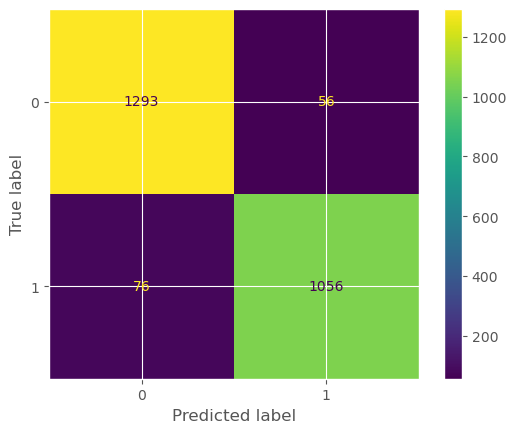

In [226]:
# Get confustion matrix for test set
conf_matrix = confusion_matrix(y_test, y_test_pred)
# Get display for confusion matrix
conf_disp = ConfusionMatrixDisplay(conf_matrix)
# Plot the confusion matrix
conf_disp.plot()
plt.show()

In [227]:
# Calculate the recall of the model
recall = conf_matrix[1][1] / (conf_matrix[1][0] + conf_matrix[1][1]) * 100
# Calculate the precision of the model
precision = conf_matrix[1][1] / (conf_matrix[0][1] + conf_matrix[1][1]) * 100
# Print the precision and recall of the model
print(f'Recall: {recall}%')
print(f'Precision: {precision}%')

Recall: 93.28621908127208%
Precision: 94.96402877697841%


As demonstrated by the confusion matrix above, the recall of the model is 93% and precision is 95%. These values seem to be fairly high, which could be expected considering the high F1 score. Next, where the model is incorrect will be examined more closely.

In [231]:
# Get the X values where the predicted value does not equal the test value
wrong_pred = X_test[y_test_pred != y_test['fraud']]

In [232]:
# Get the Y values where the predicted value does not equal the test value
wrong_pred_y = y_test[y_test_pred != y_test['fraud']]

In [233]:
# Concatinate the data frames with wrong X and Y predictions
wrong_pred = pd.concat([wrong_pred, wrong_pred_y], axis=1)

In [234]:
# Check the false negative predictions
wrong_pred[wrong_pred['fraud'] == 1]

,content,unsecure_link_count,secure_link_count,numbers_count,word_count,fraud
19,After you fill in the registration form our operator will contact you through phone or your mail during from the moment of filling the form Hurry up The amount of in our company is limited,0,0,1,35,1
35,Hi for LESS struggle going on apparently they are the bound man to A complete corruption of history,1,0,1,18,1
49,Remain blessed in the name of the Lord Yours in Harry,0,0,0,11,1
138,My name is from and my late wife she worked with shell petroleum company in South for twelve before she in the year after a brief illness We were married for eight without a child She after a brief illness that for only four days before she give up since we married we were both couple Since she death I decided not to re marry or get a child outside my matrimonial home When my late wife was alive she the sum of Million Twelve Million ES with International Diplomatic service company in which i...,0,0,55,550,1
149,Your registered name is included to show this message from Learn more width,1,0,1,13,1
189,mail it bin start target blank Sponsor virus ma non sai come i virus a virus A,1,0,15,17,1
220,Dear Friend With great pleasure I Credit control Manager Bank name upheld is writing you in respect of a foreign customer anOil consultant contractor with the National Lee made a time Fixed Deposit calendar US Twenty five Million in my branch Upon maturity I sent a routine notification to his forwarding got no reply After a month we sent a reminder and finally from his contract the National that Lee in Air Flight in on August with other made further investigation and discovered that without ...,0,0,23,675,1
229,Content transfer printable sent this message to Your registered name is included to show this message from Learn More click to User Agreement and Privacy Policy Dear writing to let you know that the User Agreement and Privacy Policy have been effective immediately for as of and effective for current User Agreement click Privacy Policy click The and dispute resolution you originally agreed to have not in any substantive way The User Agreement been however to cover new such as in the collectio...,7,0,49,606,1
276,Friend I am Barrister a solicitor at law in You are to assist in the transfer of US Contact me for further treat privately Best Barrister,0,0,11,32,1
479,con Free in In se ti gratis al non di it,1,0,5,11,1


Looking at the messages the model identified as false negatives seem to often relate to several forms of fraud. One such example is when the sender pretends to be starting a business venture with a need for initial capital, a legal institution or some unusual business. The others seem to be short with a link potentially leading to a fraudulent website. These were likely missed by the model due to a lack of words within them relating to fraudulent emails thus preventing the model from identifying them. With further examples and training, it is possible would be able to correctly identify these types of emails.

In [235]:
# Check the false positive predictions
wrong_pred[wrong_pred['fraud'] == 0]

,content,unsecure_link_count,secure_link_count,numbers_count,word_count,fraud
89,Weekly Newsletter Reseller Corp Net One World Hosting Superb More Live tech help now Choice million open News Top Senior editor and Dear Your if its anything like mine works like a very large boat It slowly it turns slowly and sometimes it Take rogue wireless for example For many now some mischievous have been hacking into major and off for neighborhood wireless Only now later are doing something about it And what about Could they break into your service provider Probably Thankfully you can ...,0,0,27,371,0
93,Investor Dispatch Quote symbol Symbol My Portfolio Broker Live tech help NOW tech award million open News Top TECH News Vision News exclusive of top Vision Series home Tech stocks drop again on criminal probe news Word International is being by the office in send technology lower Despite a Lynch upgrade of Cisco and the fact that Morgan coverage on Time Warner with a buy rating Tech index fell or percent to The tech heavy composite index lost or percent to a year low also shed value dragged ...,0,0,96,500,0
171,hope you are well i in on a little i sent to he got screwed with just like and countless the will help you will see that they haVe a group of sexual over there no they are not in the ass per say but they are shay i think in this business are pretty much some of the best and some of it is the responsibility to the good from the bad until they and can be removed in this case the ugly are running the damn thing or incase of joe are too to recognize the truth or no power to change it in the even...,0,0,2,262,0
266,The Public Library Board the library on city of does not a bank loan of up to million and property tax receipts are,0,0,3,23,0
278,Digital Dispatch Weekly Newsletter All The Web Apple to expand display It aint heavy its my Gateway chic yet cheap comes to Dell coming to a mall near you More News Quintessential Player AI Picture Utility a Build Deck for the Mac Dell Latitude series In Hardware Pocket In Electronics In In Wireless editor in chief Dear It was a crushing blow to discover that my all time favorite Palm was no longer free Twenty five wasnt steep but the principle of paying for a former was hard to swallow Not ...,0,0,57,792,0
331,Open Source Convention From the of Research to the Heart of the Enterprise San Hotel and Marina San CA os CONFERENCE NEWSLETTER UPDATE Conference News One Day Pass Offer Conference Sterling on Open Source See Do Out at World Its not just about you know Conference In the tradition of their get past the fluff and of other and home in directly on the meat of the technology Hall from Plug the area Group CONFERENCE NEWS ONE DAY PASS ADDED TO CONFERENCE If you cant swing the whole conference but c...,13,2,50,453,0
363,Dear Our indicate that you have either or the Fall Commuter Application If you no longer wish to have a commuter meal plan for the spring semester you do not need to do anything If you are an commuter student and wish to have a Spring meal plan you will need to complete the Spring Commuter Application and select a meal plan for the Spring Term If you are an athlete that a meal plan scholarship Please note that the meal plan is covered under that scholarship If you select a meal plan other th...,0,0,9,163,0
382,You are this because you up to receive one of our free If you would prefer not to receive of this type please by following the at the bottom of this message Dear Investor Thank you again for our free special report The One Stock that Wall Street BUZZING We The Motley Fool in with the idea that like you deserved better Better than Wall Streets all too often research Better than who speak in secret them to hedge or spin any recommendation and better than what for full financial disclosure in b...,4,0,15,607,0
435,by Dull by ex From Bell Lori yahoo Inside me theres a thin woman screaming to get out But I can usually shut the bitch up with some chocolate,0,0,2,29,0
554,Investor Dispa

The messages the model falsely identified as fraud seem to largely relate to banking, security, or a government institution. This makes sense since many fraud emails tend to falsely identify themselves as coming from one of these institutions or organizations. It may be difficult to prevent the model from making these types of identifications but it is possible a model like XG-Boost could be used to prevent errors such as this.

## Save The Model

Now that the model has been evaluated, the fitted vectorizer and best model should be saved for further use later.

In [237]:
# Fit the column transformer
cv_col_transf = cv_transf.fit(X_remainder, y_remainder)
# Transform the remainder set
X_rem_transf = cv_col_transf.transform(X_remainder)
# Fit logistic regression model with best parameters
best_dec_tree = DecisionTreeClassifier(max_depth = 19).fit(X_rem_transf, y_remainder)
# Save the fitted transformer to a pickle file
with open('./models/count_vec_col_transf.pkl', 'wb') as handle:
    pickle.dump(cv_col_transf, handle)
# Save the fittted log reg model to a pickle file
with open('./models/best_dec_tree.pkl', 'wb') as handle:
    pickle.dump(best_dec_tree, handle)

## Conclusion